## Section E: Bayesian Optimisation for Chemical Reaction Optimisation: Example Application of BO

Well done for powering through the previous sections! Using our understanding of the basics of Bayesian Optimisation, we shall now observe an application of Bayesian Optimisation: Chemical Reaction Optimisation.

This notebook is geared towards showing how the fundemental principals of BO can be applied. There are numerous open source packages that integrates BO to a reaction optimisation workflow without having to perform any mathematical/statistical coding. These are linked at the end of the notebook. 

Running a reaction condition optimisation campaign can be cumbersome as experimentation can be time consuming especially under the vast combinatorial domain of the input reaction condition search space (reagent identities, equivalences, solvent identities, reaction temperature etc.). Bayesian Optimisation could be a useful method to make better decisions (balance of exploration and exploitation conditioned on known expeirmental outcomes) when deciding on which experiments to run. 


### Importing relevant packages
(Feel free to import any packages you feel like needing to fully explore the content!)

In [ ]:
# if using google collab, run the following pip installs!
!pip install sobol_seq
!pip install plotly
!pip install gpytorch
!pip install rdkit

In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.integrate import quad
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
import math
import time
import sobol_seq


## Introduction to Reaction Optimisation with BO

We are now going to use our batch BO workflow to run for an optimisation campaign for a chemical reaction! The case study can be found in this reference.

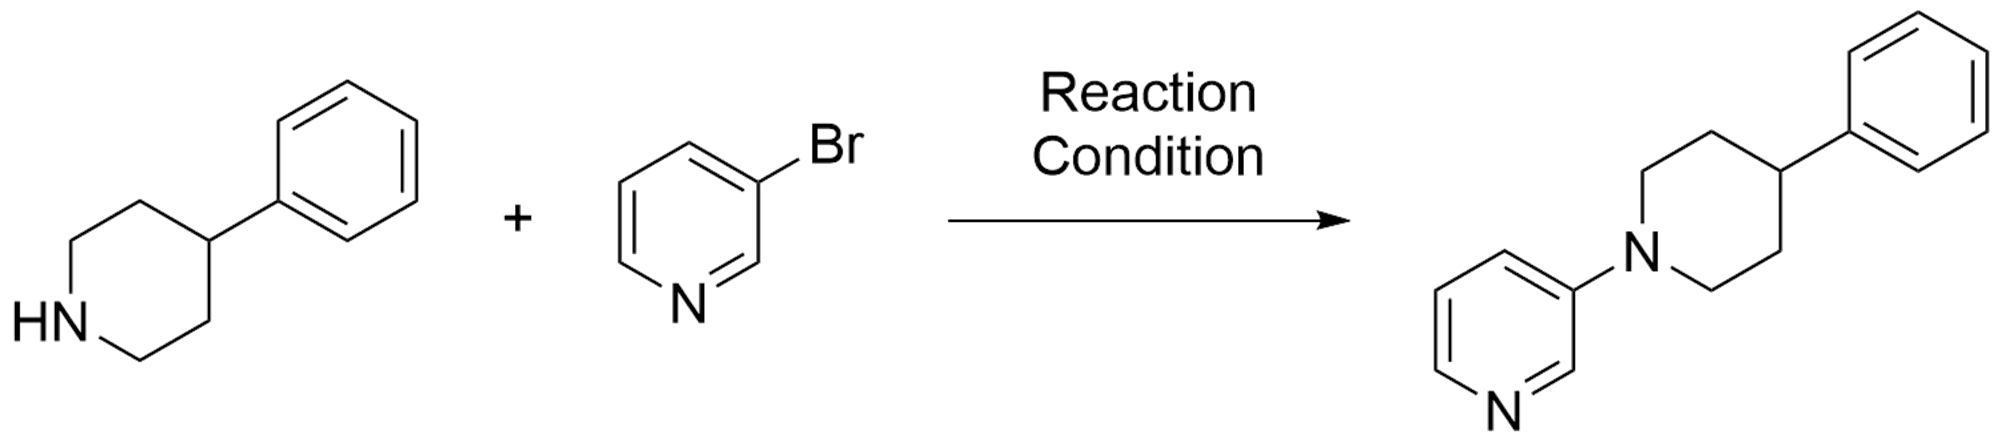

Alexander Buitrago Santanilla et al. ,Nanomole-scale high-throughput chemistry for the synthesis of complex molecules.Science347,49-53(2015).DOI:<a href="https://www.science.org/doi/10.1126/science.1259203">10.1126/science.1259203</a>

The reaction condition space for a particular chemical transformation can be extremely vast due to the combinatorial nature of variables (especially if the reaction is not established). For example, our case study is a Buchwald-Hartwig amination (C-N cross coupling) which requires a palladium catalyst, ligand, base and solvent. Just considering 10 chemicals for each reagent will lead to a space of 10000 possible reaction conditions! 

Bayesian Optimisation provides a systematic, data-driven way of choosing which experiments to perform. We will only be considering 2 variables in the optimisation of this reaction: The pre-catalyst and base. Our goal is to obtain the reaction condition with the highest yield (which combination of base and pre-catlayst gives the highest yield?). Below is the list of pre-catalyst and bases we will be examining. 

A word about the pre-catalyst: Pre-catalysts are precursors to the active catalyst for a catalytic reaction. They are often have the catalytic center (the metal atom) and the ligand pre-bonded such that the pre-catalyst can be directly used or dispense for a reaction. There are 4 generations to the palladium pre-catalyst. This case study uses the 2nd and 3rd generation of precatalyst. The structures of the pre-catlaysts, ligands and bases are seen below (L = ligand).

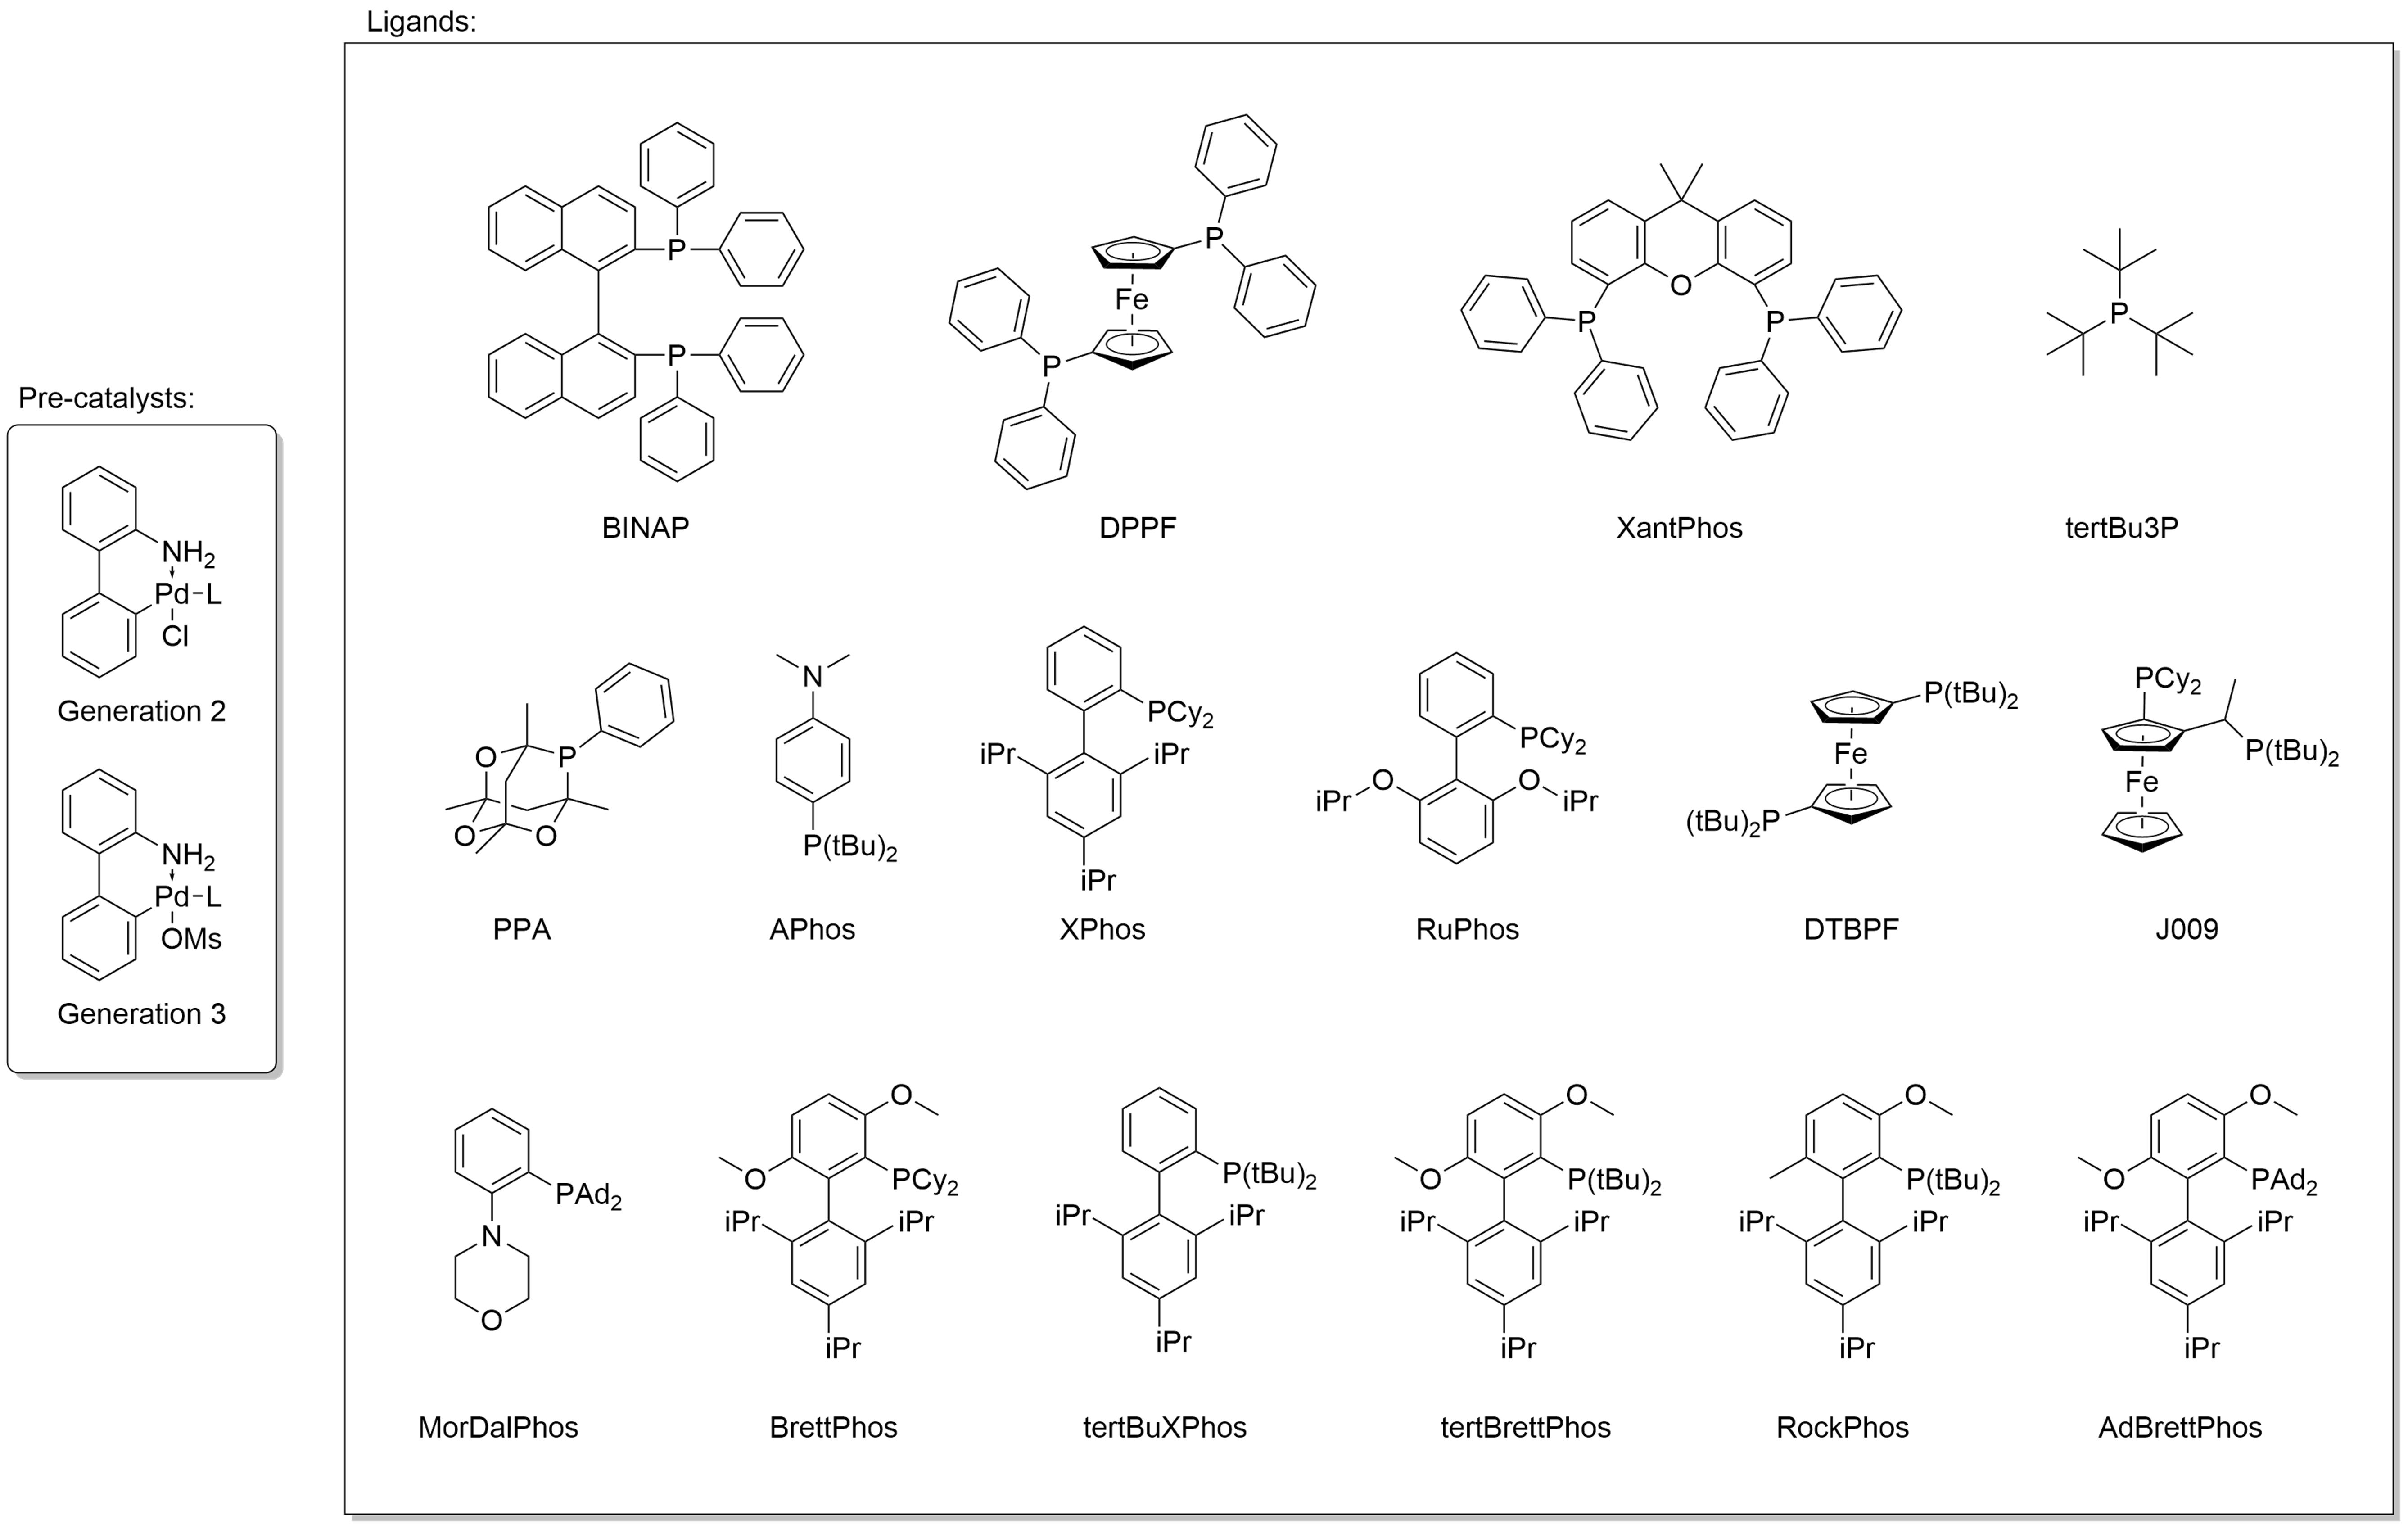
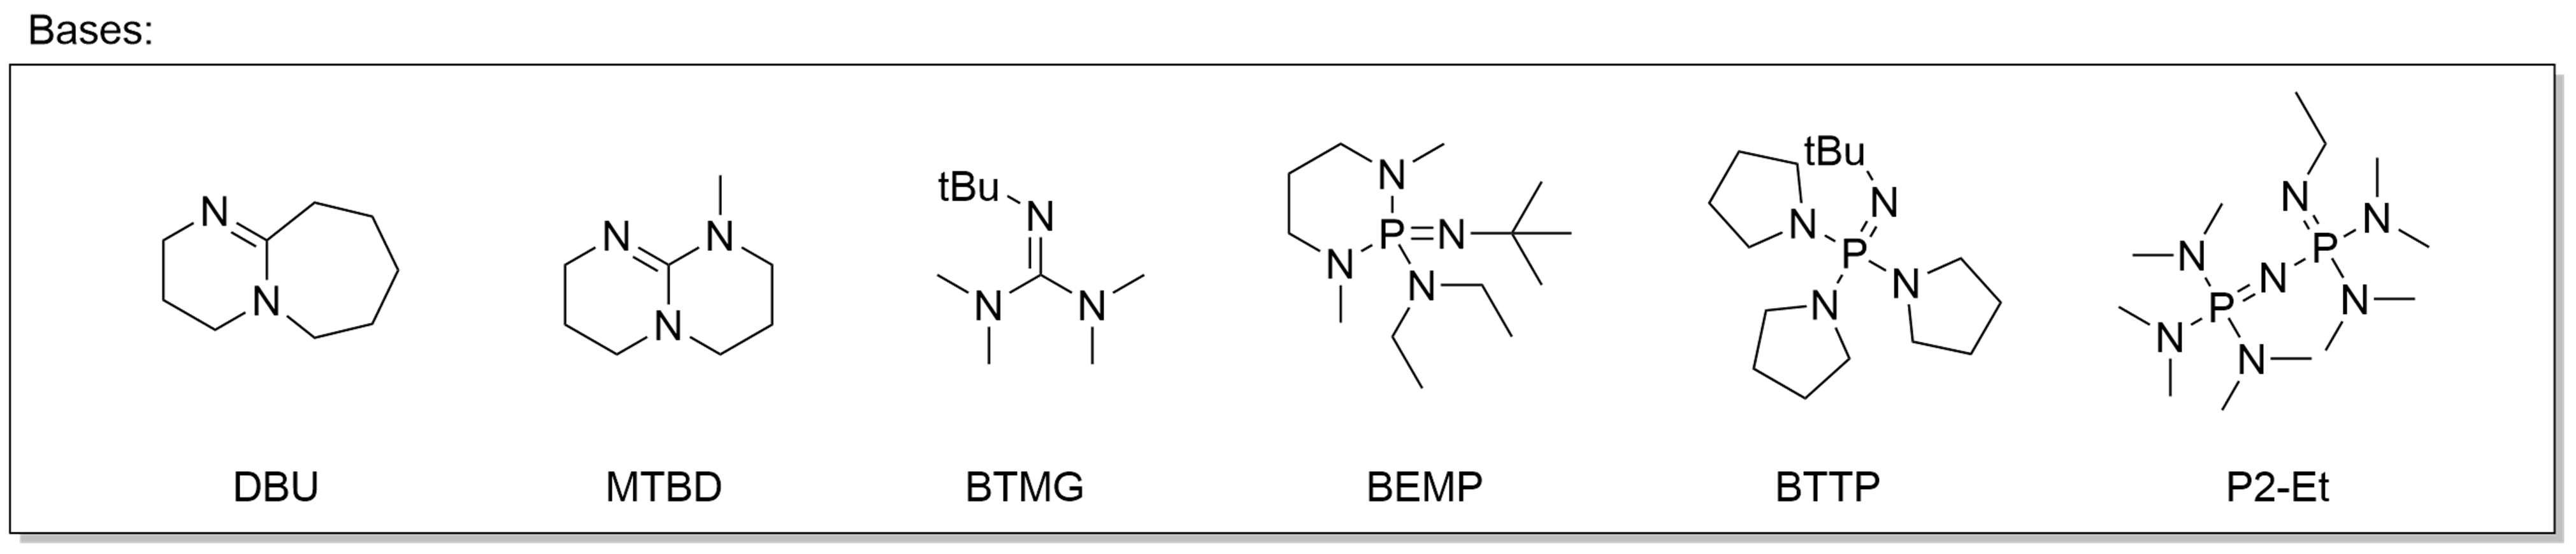

In [26]:
precatalyst = ['G3_BINAP', 
               'G3_DPPF',
               'G2_XantPhos',
               'G2_tertBu3P',
               'G3_PPA',
               'G3_Aphos',
               'G3_Xphos',
               'G2_RuPhos',
               'G3_DTBPF',
               'G3_J009',
               'G3_MorDalPhos',
               'G3_BrettPhos',
               'G3_tertBuXPhos',
               'G3_tertBuBrettPhos',
               'G3_RockPhos',
               'G3_AdBrettPhos']
base = ['DBU',
        'MTBD',
        'BTMG',
        'BEMP',
        'BTTP',
        'P2Et']

#### Excersise B1_1: 
##### Concepts: Chemical Descriptors

Before perfoming BO, we have to convert the pre-catalysts and bases into a machine-readable form. GP regressors are not able to process each reagent just from the names. We have to translate the chemical identities into a numerical number such that the GP can not only interpret them but also draw relations between them (via the mean and covariance matrix). There are many ways one can generate descriptor for each molecule. 

A few include the use of density functional theory descriptors, cheminformatics descriptors, fingerprinting, experimental values etc. There are whole databases dedicated to the generation and storage of descriptors. <a href="https://descriptor-libraries.molssi.org/kraken/">An example is the KRAKEN data base for ligands. </a> 

The best descriptors are ones which directly relate to the outcome of the reaction. For example, if a base of higher pKaH value leads to a higher yield, then pKaH would be a good descriptor. However, it is rare to know prior to the optimisation of the reaction (or similar reactions) if a descriptors is suitable. There are many examples of chemical optimisation of BO that take the dimensionally reduced components of a very long list of descriptors.

However, for demonstration purposes, we will stick to some simple descriptors such as molecular mass for the pre-catalyst and pKaH for the bases. 

```python
precatalyst_descriptors = [['G3_BINAP',[622.20]],
                           ['G3_DPPF',[544.10]],
                           ['G2_XantPhos',[578.19]],
                           ['G2_tertBu3P',[202.19]],
                           ['G3_PPA',[292.12]],
                           ['G3_Aphos',[265.20]],
                           ['G3_Xphos',[476.36]],
                           ['G2_RuPhos',[466.30]],
                           ['G3_DTBPF',[474.23]],
                           ['G3_J009',[554.29]],
                           ['G3_MorDalPhos',[463.30]],
                           ['G3_BrettPhos',[536.38]],
                           ['G3_tertBuXPhos',[424.33]],
                           ['G3_tertBuBrettPhos',[484.35]],
                           ['G3_RockPhos',[468.35]],
                           ['G3_AdBrettPhos',[640.44]]]

base_descriptors = [['DBU', [24.3]],
                    ['MTBD', [25.5]],
                    ['BTMG', [23.6]],
                    ['BEMP', [27.6]],
                    ['BTTP', [28.4]],
                    ['P2Et', [32.9]]]
```

Can you find some alternative descriptors for the precatalyst and base? We will used this to perform BO and evaluate which set of descriptors are better. 

#### Excersise B1_2: 
##### Concepts: Optimisation of Chemical Reactions with BO 

We can now perform some BO! Usually, the evaluation of the reaction condition will involve experimentation. In this case, an objective function (with a delay in the BO class) will be used to emulate experimentation. This objective function takes in the descriptors and searches in the search space for the index with matching descriptors and returns the yield as a function of the index. 

It is therefore very important that the search space is built in the same order as the yield list! (the notebook will explicitly provide the order in which the search space is to be built. 

Since we have built a BO algorithm to minimise, the yields are inverted into the negative space such that minimisation will conrespond to obtaining the highest yield. 

```python
reaction_yield = [-3.6, -3.9, -3.5, -3.3, -3.6, -3.0, -1.1, -0.7, -0.8, -0.6, -0.8, -1.2, -0.7, -1.5, -0.0, -0.0, -0.0, -0.5, -5.0, -0.0, -0.0, -1.6, -3.5, -6.6, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.5, -1.5, -0.0, -0.0, -0.0, -0.7, -0.0, -1.6, -0.0, -1.3, -2.2, -23.2, -0.0, -0.0, -0.0, -1.9, -4.0, -16.3, -4.0, -1.0, -0.0, -0.0, -0.0, -62.7, -0.4, -1.8, -1.7, -1.0, -0.0, -0.0, -0.1, -0.3, -0.3, -0.4, -0.4, -2.8, -1.1, -1.4, -2.6, -0.7, -1.4, -2.1, -10.9, -91.7, -100.0, -50.2, -27.8, -79.1, -0.0, -3.1, -0.0, -1.2, -1.8, -14.5, -0.5, -0.5, -0.0, -0.4, -0.6, -7.8, -3.1, -3.5, -3.2, -2.2, -3.0, -15.8]

def experiment_yield(condition , X_searchspace):
    return(reaction_yield[X_searchspace.index(condition)])

#ordering of the search space is very important
X_searchspace = []
for precat in precatalyst_descriptors:
    for base in base_descriptors:
        X_searchspace += [precat[1]+base[1]]

```

Code for batch BO using marginal Thompson Sampling and Squared Exponential kernel functions is observed below. 

```python
class BO_multiD_batch_chemistry: 
    def __init__(self, X, kernel, X_searchspace, iterations,acquisition_function, objective_func,print_graph, acquisition_hyperparam, batch, experiment_time):

        self.X = np.array(X)
        Fx_training = np.array([objective_func(x.tolist(),X_searchspace) for x in self.X])
        self.Y = Fx_training.reshape(-1, 1)
        
        self.minY = []
        self.exploredY = []

        for i in range(iterations):
            GP_m = GP_model_meanzero(self.X, self.Y, kernel, hyperparams_multistart_loops=3)

            means = np.zeros(len(X_searchspace))
            varience  = np.zeros(len(X_searchspace))
            for idx, xx in enumerate(X_searchspace):
                m, v = GP_m.GP_inference_np(xx)
                means[idx] = m.item()
                varience[idx]  = v.item()

            
            if acquisition_function == 'ThompsonMarginal':
                new_X = []
                for number in range(batch): 
                    ts_sample  = means + acquisition_hyperparam[0]*np.sqrt(varience)*np.random.randn(len(X_searchspace))
                    new_X.append(X_searchspace[np.argmin(ts_sample)])
                new_X = np.array(new_X)
            else: 
                print('No acquisition function named', acquisition_function)

            time.sleep(experiment_time)
            new_Y = np.array([objective_func(x.tolist(),X_searchspace) for x in new_X]).reshape(-1, 1)
            self.X = np.vstack([self.X, new_X])
            self.Y = np.vstack([self.Y, new_Y])

            self.minY     += [self.Y.min()]
            self.exploredY += [new_Y.flatten().tolist()]

            if print_graph:
                print(f"Iteration {i} complete.")

        plt.figure(figsize=(8,4), dpi=100)
        plt.title('Minimum of Training Data set over Iterations')
        plt.xlabel('Iterations')
        plt.plot(range(iterations), self.minY)
        plt.show()

        plt.figure(figsize=(8,4), dpi=100)
        plt.title('Evaluation Output over Iterations')
        plt.xlabel('Iterations')
        for i, vals in enumerate(self.exploredY):
            plt.scatter([i]*batch, vals)
        plt.show()

BO_m = BO_multiD_batch_chemistry(X = X_training,  
                                 kernel = 'SquaredExponential', 
                                 X_searchspace = X_searchspace, 
                                 iterations = 15, 
                                 acquisition_function = 'ThompsonMarginal', 
                                 objective_func = experiment_yield, 
                                 print_graph = True, 
                                 acquisition_hyperparam=[3], 
                                 batch = 5,
                                 experiment_time = 0)

```

Using this code, start your first reaction optimisation campaign using BO! (We can leave the experiment_time to 0 for now.) Start with 3 training data points - these must be in the correct order of precatayst descriptors first then base descriptors. For example: 

```python
X_training = [[544.1, 32.9],[265.2, 24.3],[640.44, 25.5]]
```

#### Excersise B1_3:
##### Concepts: Optimisation of Chemical Reactions with BO

We can also use multidimensional desciptors for each molecule! This is usually beneficial especially when there are multiple factors that contribute towards the goal. (For example, when sterics and electronic properties of the molecule affects the outcome). However, as seen previously, the more dimensions, the longer the time the BO will take. For now, lets observe an example of a 2D input for the precatalyst.

With higher dimensions, it is required that the training data include at least 2 different data points for the same dimension. Otherwise you will get an error (the covariance matrix cannot be formed).

```python
precatalyst_descriptors = [['G3_BINAP',[622.20, 2]],
                           ['G3_DPPF',[544.10, 2]],
                           ['G2_XantPhos',[578.19, 2]],
                           ['G2_tertBu3P',[202.19, 1]],
                           ['G3_PPA',[292.12, 1]],
                           ['G3_Aphos',[265.20, 1]],
                           ['G3_Xphos',[476.36, 1]],
                           ['G2_RuPhos',[466.30, 1]],
                           ['G3_DTBPF',[474.23, 2]],
                           ['G3_J009',[554.29, 2]],
                           ['G3_MorDalPhos',[463.30, 1]],
                           ['G3_BrettPhos',[536.38, 1]],
                           ['G3_tertBuXPhos',[424.33, 1]],
                           ['G3_tertBuBrettPhos',[484.35, 1]],
                           ['G3_RockPhos',[468.35, 1]],
                           ['G3_AdBrettPhos',[640.44, 1]]]

base_descriptors = [['DBU', [24.3]],
                    ['MTBD', [25.5]],
                    ['BTMG', [23.6]],
                    ['BEMP', [27.6]],
                    ['BTTP', [28.4]],
                    ['P2Et', [32.9]]]

X_training = [[544.1, 2, 32.9],[265.2, 1, 24.3],[640.44, 1, 25.5], [622.20, 2, 28.4]]
X_searchspace = []
for precat in precatalyst_descriptors:
    for base in base_descriptors:
        X_searchspace += [precat[1]+base[1]]

BO_m = BO_multiD_batch_chemistry(X = X_training,  
   kernel = 'SquaredExponential', 
   X_searchspace = X_searchspace, 
   iterations = 15, 
   acquisition_function = 'ThompsonMarginal', 
   objective_func = experiment_yield, 
   print_graph = True, 
   acquisition_hyperparam=[3], 
   batch = 5, 
   experiment_time=0)
```

#### Excersise B1_4:
##### Concepts: Optimisation of Chemical Reactions with BO

Well done! Now that you have succesfully run a BO optimisation campaign and known the various aspects of BO. Please explore how changing various aspects of the input (hyperparameters, descriptors, iterations vs batch size for a given budget etc.), changing the code (a different acquisition function etc.) affect the performance and runtime of the code.


### Resources for practical BO

Well done! You have now a basic understanding of how one could apply BO for chemical reaction optimisation. As mentioned in the introduction, there are a number of python packages which integrate BO into a reaction optimisation workflow without requiring the explicit need for mathematical/statistical coding. Attached below are some resources and links to further tutorials. 

#### BO packages for Chemical Reaction Optimisation
1. EDBO+ 
- Created by the Doyle Lab (UCLA); see paper: 10.1021/jacs.2c08592 
- Contains webapp for Bayesian Optimisation for Reaction Optimisation (No coding required!)
- Can perform multi-objective reaction optimisation
- Github Repo (contains tutorials for use): https://github.com/doyle-lab-ucla/edboplus/tree/main
- Webapp: https://edboplus.org

2. BayBE
- Documentation: https://emdgroup.github.io/baybe/stable/index.html 
- Created by Merck KGaA and Acceleration Consortium - highlighted as the practical BO option for chemistry/materials optimisation problems
- Contains many features which are useful for chemistry specific applications including custom/built-in parameter encodings (descriptors)
- Can be used as basis for Transfer Learning on top of BO functionality
- Can be used for distributed/asynchronous workflows (pending or partial measurements) 

3. BOFire
- Documentation: https://experimental-design.github.io/bofire/
- Created by many partners including Evonik, BASF, Imperial College London etc. 
- Contains many features which are useful for chemistry specific applications including custom/built-in parameter encodings (descriptors)
- Includes JSON/serialisation + REST integration to interface with automation stacks/ human-in-the-loop pipelines


#### Packages/Resources Obtaining Descriptors
1. rdkit
- https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors  
- global descriptors (rdkit.Chem.rdMolDescriptors builds 217 including 3D descriptors)
- fingerprinting (Morgan (ECFP), Morgan count, topological, MACCS)

2. Mordred Community 
- https://github.com/JacksonBurns/mordred-community
- Community maintained version of the original mordred molecular descriptor calculator
- total of 2008 global descriptors available (including all from rdkit) 

3. PaDEL 
- Java software, but wrapper for python avaiable: https://github.com/ecrl/padelpy
- total of 1875 global descriptors and 12 fingerprint types
- for global descriptors (and optional fingerprints)
- used in DOPtools (descriptor calculation and model optimisation package); paper: 10.1039/D4DD00399C 

4. auto-qchem
- Workflow developed by Dolye Group (UCLA) to obtain and store DFT descriptors
- Github: https://github.com/doyle-lab-ucla/auto-qchem
- Paper: 10.1039/D2RE00030J 
